In [2]:
from sklearn.cluster import KMeans, SpectralClustering
import scipy.io as spio
import matplotlib.pyplot as plt
import numpy as np
import online_dictionary_learning.omp as omp
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
IP_data_mat=spio.loadmat("data/IP/Indian_pines_corrected.mat")
IP_gt_mat=spio.loadmat("data/IP/Indian_pines_gt.mat")
IP_image=IP_data_mat["indian_pines_corrected"]
IP_gt=IP_gt_mat['indian_pines_gt']

pavia_mat = spio.loadmat('data/PaviaU/PaviaU.mat')
pavia_gt_mat = spio.loadmat('data/PaviaU/PaviaU_gt.mat')
pavia_image = pavia_mat['paviaU']
pavia_gt = pavia_gt_mat['paviaU_gt']

salinas_mat = spio.loadmat('data/Salinas/salinas.mat')
salinas_gt_mat = spio.loadmat('data/Salinas/salinas_gt.mat')
salinas_image = salinas_mat['salinasA_corrected']
salinas_gt = salinas_gt_mat['salinasA_gt']

salinas_dictionary = np.load('results/Salinas/t5000_k220_L2.npy')
IP_dictionary = np.load('results/Indian_Pines/t5000_k220_L2.npy')
pavia_dictionary = np.load('results/Pavia/t5000_k120_L2.npy')

In [4]:
def randIndex(gt_labels, pred_labels):
    return adjusted_mutual_info_score(np.reshape(gt_labels, -1), np.reshape(pred_labels, -1), average_method='warn')

In [5]:
def kmeans_compare(image, gt, dictionary, verbose=False, L=5):
    # Original shape of image
    original_shape = gt.shape
    # flatten image and gt data
    image_flat = np.reshape(image, (-1, image.shape[2]))
    gt_flat = np.reshape(gt, (-1))
    # Remove Misc. Data
    image_flat = image_flat[gt_flat!=0]
    
    # Compute Sparse Coefficients
    coefs = np.zeros((image_flat.shape[0], dictionary.shape[1]))
    
    if verbose:
        print('Computing sparse coefficients:\n')
    
    for i in range(coefs.shape[0]):
        coefs[i]=omp.omp(dictionary, image_flat[i], L=L, eps=None)
        if verbose:
            if i+1<image_flat.shape[0]:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\r')
            else:
                print('[' + str(i+1) + '] ' + str(np.round(((i+1)/image_flat.shape[0])*100,2)) + '%', end='\n')

    # Run K-Means for both data sets
    k = np.unique(gt_flat).shape[0]-1
    kmeans_o = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=0).fit(coefs)
    # kmeans_o = KMeans(n_clusters=k, random_state=0).fit(image_flat)
    kmeans_s = SpectralClustering(n_clusters=k, random_state=0, affinity='nearest_neighbors').fit(image_flat)
    
    # Get labels
    labels_o = kmeans_o.labels_
    labels_s = kmeans_s.labels_
    
    # Reconstruct Images
    
    count, loc, n = 0, 0, gt_flat.shape[0]
    final_o, final_s = np.zeros(n), np.zeros(n)
    while count<labels_o.shape[0]:
        if (gt_flat[loc]!=0):
            final_o[loc]=labels_o[count]+1
            final_s[loc]=labels_s[count]+1
            count+=1
        loc+=1
    

    # Reshape
    final_o, final_s = np.reshape(final_o, original_shape), np.reshape(final_s, original_shape)
    
    # Return
    return [final_o, final_s]

/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


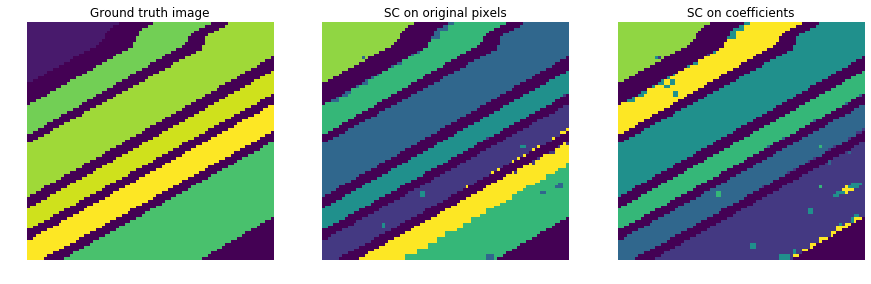

In [6]:
clusterings_sal = kmeans_compare(image=salinas_image, gt=salinas_gt, dictionary=salinas_dictionary, verbose=False)

f, ax = plt.subplots(1, 3, figsize=(15,15))
ax[0].imshow(salinas_gt)
ax[2].imshow(clusterings_sal[0])
ax[1].imshow(clusterings_sal[1])
ax[0].title.set_text('Ground truth image')
ax[2].title.set_text('SC on coefficients')
ax[1].title.set_text('SC on original pixels')
plt.savefig('spectral_result.png')

for a in ax:
    a.axis('off')

plt.savefig('Salinas_spectral_comparison')
plt.show()

In [ ]:
# clusterings_IP = kmeans_compare(image=IP_image, gt=IP_gt, dictionary=IP_dictionary, verbose=False)

# f, ax = plt.subplots(1, 3, figsize=(15,15))
# ax[0].imshow(IP_gt)
# ax[1].imshow(clusterings_IP[0])
# ax[2].imshow(clusterings_IP[1])
# ax[0].title.set_text('Ground truth image')
# ax[1].title.set_text('SC on coefficients')
# ax[2].title.set_text('SC on original pixels')
# plt.savefig('spectral_result.png')

# for a in ax:
#     a.axis('off')

# plt.show()

In [ ]:
# clusterings_pav = kmeans_compare(image=pavia_image, gt=pavia_gt, dictionary=pavia_dictionary, verbose=False)

# f, ax = plt.subplots(1, 3, figsize=(15,15))
# ax[0].imshow(pavia_gt)
# ax[1].imshow(clusterings_pav[0])
# ax[2].imshow(clusterings_pav[1])
# ax[0].title.set_text('Ground truth image')
# ax[1].title.set_text('SC on coefficients')
# ax[2].title.set_text('SC on original pixels')
# plt.savefig('spectral_result.png')

# for a in ax:
#     a.axis('off')

# plt.show()

In [7]:
salinas_sc_ri = randIndex(salinas_gt, clusterings_sal[0]) 
salinas_op_ri = randIndex(salinas_gt, clusterings_sal[1])

# IP_sc_ri = randIndex(IP_gt, clusterings_IP[0])
# IP_op_ri = randIndex(IP_gt, clusterings_IP[1])

# pavia_sc_ri = randIndex(pavia_gt, clusterings_pav[0])
# pavia_op_ri = randIndex(pavia_gt, clusterings_pav[1])

print("For Salinas the AMIS is %f on coefs and %f on pixels.\n"%(salinas_sc_ri, salinas_op_ri))
# print("For IP the AMIS is %f on coefs and %f on pixels.\n"%(IP_sc_ri, IP_op_ri))
# print("For Pavia the AMIS is %f on coefs and %f on pixels.\n"%(pavia_sc_ri, pavia_op_ri))

For Salinas the AMIS is 0.948661 on coefs and 0.898056 on pixels.



/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


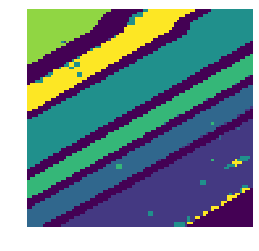

In [8]:
plt.imshow(clusterings_sal[0])
plt.axis('off')
plt.savefig('clusterings_sal_sc.jpg')
plt.show()

In [9]:
def PCA_clustering(image, gt, n_components):
    # Preprocessing
    m, n, c = np.array(image).shape
    image_flat = np.reshape(image, (m*n, c))
    gt_flat = np.reshape(gt, -1)
    image_flat = np.array(image_flat, dtype=np.float64)
    
    # Standardise the data
    image_std = StandardScaler().fit_transform(image_flat)
    
    # PCA
    pca = PCA(n_components=n_components)
    pCs = pca.fit_transform(image_std)
    
    # KMeans
    k = np.unique(gt_flat).shape[0]-1
    pCs = pCs[gt_flat!=0]
    image_flat = image_flat[gt_flat!=0]
    
    kmeans = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=0).fit(pCs)
    
    labels = kmeans.labels_
    
    # Reconstruct Images
    count, loc, n = 0, 0, gt_flat.shape[0]
    final = np.zeros(n)
    while count<labels.shape[0]:
        if (gt_flat[loc]!=0):
            final[loc]=labels[count]+1
            count+=1
        loc+=1
    
    final = np.reshape(final, gt.shape)
    return final

In [10]:
pca_labels = PCA_clustering(salinas_image, salinas_gt, 50)

/home/joshua/anaconda3/lib/python3.7/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


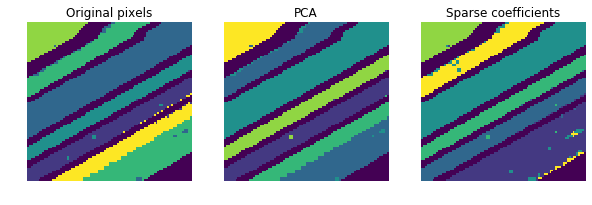

In [11]:
f, ax = plt.subplots(1, 3, figsize=(10,10))
ax[0].imshow(clusterings_sal[1])
ax[1].imshow(pca_labels)
ax[2].imshow(clusterings_sal[0])
ax[0].title.set_text('Original pixels')
ax[1].title.set_text('PCA')
ax[2].title.set_text('Sparse coefficients')

for a in ax:
    a.axis('off')

plt.savefig('final_comparison.png')
plt.show()